In [0]:
from scipy.signal import convolve
import numpy as np

In [5]:
# 합성곱 하기
x = [1,2,3,4,5,6,7,8,9]
w = [1,2,1,2]  # w가 [2,1,2,1]로 바뀌어서 원소간의 곱이 이루어진다.
print(convolve(x, w, mode='valid'))

[14 20 26 32 38 44]


In [8]:
# CNN에 사용되는 것은 교차상관
from scipy.signal import correlate
correlate(x, w, mode='valid')  # 제로 패딩이 없는 valid 패딩

array([16, 22, 28, 34, 40, 46])

In [9]:
print(correlate(x,w, mode='full'))  # 모든 x의 원소가 연산에 같은수로 참여하는 연산
print(correlate(x,w, mode='same'))  # in과 out이 같은 수의 원소를 갖는 연산, 대부분 same패딩 사용

[ 2  5 10 16 22 28 34 40 46 32 26  9]
[ 5 10 16 22 28 34 40 46 32]


In [10]:
x1 = np.array([[1,2,3],[4,5,6],[7,8,9]])
w1 = np.array([[2,0],[0,0]])
# 2차원 배열의 합성곡 계산
from scipy.signal import correlate2d
correlate2d(x1, w1, mode='valid')  # valid 패딩을 적용했을 때

array([[ 2,  4],
       [ 8, 10]])

In [11]:
correlate2d(x1, w1, mode='same')  # same 패딩을 적용했을 때... 홀로그램 이미지의 경우 valid 패딩으로 차원의 갯수를 줄이는 것이 좋지 않을까 싶다

array([[ 2,  4,  6],
       [ 8, 10, 12],
       [14, 16, 18]])

In [0]:
# 텐서플로우로 합성곱 수행
import tensorflow as tf
x_4d = x1.astype(np.float).reshape(1,3,3,1)  # 배치 1, 컬러 1
w_4d = w1.reshape(2,2,1,1)  # 2 by 2, 배치1, 컬러1

cout = tf.nn.conv2d(x_4d, w_4d, strides=1, padding='SAME')

In [15]:
cout.numpy().reshape(3,3)

array([[ 2.,  4.,  6.],
       [ 8., 10., 12.],
       [14., 16., 18.]])

In [0]:
# 맥스 풀링과 에버리지 풀링을 하기
x2 = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])
x2=x2.reshape(1,4,4,1)

In [23]:
pout = tf.nn.max_pool2d(x2, ksize=2, strides=2, padding='VALID')  # 맥스풀링 커널사이즈2, 스트라이드2, valid 패딩
pout.numpy().reshape(2,2)

array([[ 6.,  8.],
       [14., 16.]], dtype=float32)

In [0]:
# relu 함수 구현하기
def relu(x):
    return np.maximum(x, 0)

In [26]:
rout = tf.nn.relu(x)
rout.numpy()

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [0]:
class Conv:
    def __init__(self, learning_rate=0.01, n_kernels=10, units=10, batch_size=32):
        self.units = units
        self.kernel_size = 3
        self.optimizer = None
        self.batch_size = batch_size
        self.losses = []
        self.val_losses = []
        self.lr = learning_rate
        self.conv_w = None
        self.conv_b = None
        self.w1 = None
        self.w2 = None
        self.b1 = None
        self.b2 = None
        self.a1 = None
        self.n_kernels = n_kernels

    def forpass(self, x):
        # 3 x 3 합성곱 연산을 수행
        cout1 = tf.nn.conv2d(x, self.conv_w, strides=1, padding='SAME') + self.conv_b
        # relu 적용
        r_out = tf.nn.relu(cout1)
        # max pooling
        p_out = tf.nn.max_pool2d(r_out, ksize=2, strides=2, padding='VALID')
        # 출력을 일렬로 펼치기
        f_out = tf.reshape(p_out, [x.shape[0], -1])
        z1 = tf.matmul(f_out, self.w1) + self.b1  # 첫 번째 층의 선형식
        a1 = tf.nn.relu(z1)  # 활성화 함수(relu) 적용
        z2 = tf.matmul(a1, self.w2) + self.b2  # 두 번째 층
        return z2
        
    def training(self, x, y):
        m = len(x)
        with tf.GradientTape() as tape: 
            z = self.forpass(x)  # 정방향 계산 수행
            loss = tf.nn.softmax_cross_entropy_with_logits(y,z)  # 손실계산
            loss = tf.reduce_mean(loss)
        weight_list = [self.conv_w, self.conv_b, self.w1, self.b1, self.w2, self.b2]
        grads = tape.gradient(loss, weight_list)
        self.optimizer.apply_gradients(zip(grads, weight_list))

    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.init_weight(x.shape, y.shape[1])
        self.optimizer = tf.optimizers.SGD(learning_rate=self.lr)
        for i in range(epochs):
            print('에포크', i, end='')
            batch_losses = []
            for x_batch, y_batch in self.gen_batch(x,y):
                print('.', end='')
                self.training(x_batch, y_batch)
                batch_losses.append(self.get_loss(x_batch, y_batch))  # 배치 손실 기록
            print()
            self.losses.append(np.mean(batch_losses))
            self.val_losses.append(self.get_loss(x_val, y_val))

    def init_weight(self, input_shape, n_classes):
        g = tf.initializers.glorot_uniform()
        self.conv_w = tf.Variable(g((3,3,1,self.n_kernels)))
        self.conv_b = tf.Variable(np.zeros(self.n_kernels), dtype=float)
        n_features = 14*14*self.n_kernels
        self.w1 = tf.Variable(g((n_features, self.units)))  # 특성 크기와 은닉층 크기
        self.b1 = tf.Variable(np.zeros(self.units), dtype=float)
        self.w2 = tf.Variable(g((self.units, n_classes)))  # 은닉층의 크기, 클래스 갯수
        self.b2 = tf.Variable(np.zeros(n_classes), dtype=float)

    def gen_batch(self, x, y):
        bins = len(x) // self.batch_size  # 미니 배치 횟수
        indexes = np.random.permutation(np.arange(len(x)))  # 인덱스 섞기
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size*i
            end = self.batch_size*(i +1)
            yield x[start:end], y[start:end]
    
    def predict(self, x):
        z = self.forpass(x)
        return np.argmax(z.numpy(), axis=1)

    def score(self, x, y):
        return np.mean(self.predict(x) == np.argmax(y, axis=1))

    def get_loss(self, x, y):
        z = self.forpass(x)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, z))
        return loss.numpy()

In [28]:
# 자동 미분
x = tf.Variable(np.array([1.0, 2.0, 3.0]))
with tf.GradientTape() as tape:
    y = x **3 + 2 * x + 5

print(tape.gradient(y, x))

tf.Tensor([ 5. 14. 29.], shape=(3,), dtype=float64)


In [31]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

from sklearn.model_selection import train_test_split as tts
x_train, x_val, y_train, y_val = tts(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

4423680/4422102 [==============================] - 0s 0us/step


In [32]:
x_train = x_train.reshape(-1,28,28,1)
x_val = x_val.reshape(-1, 28,28,1)

print(x_train.shape)

(48000, 28, 28, 1)


In [0]:
x_train = x_train / 255
x_val = x_val / 255

In [41]:
cnn = Conv(learning_rate=0.01, n_kernels=10, units=100, batch_size=128)
cnn.fit(x_train, y_train_encoded, x_val=x_val, y_val=y_val_encoded, epochs=20)

에포크 0.......................................................................................................................................................................................................................................................................................................................................................................................
에포크 1.......................................................................................................................................................................................................................................................................................................................................................................................
에포크 2.........................................................................................................................................................................................................................................

0.8696666666666667


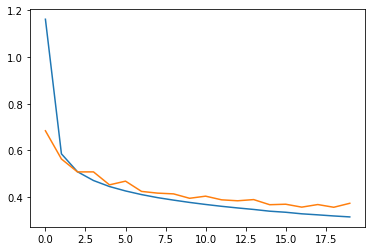

In [42]:
import matplotlib.pyplot as plt

plt.plot(cnn.losses)
plt.plot(cnn.val_losses)
print(cnn.score(x_val, y_val_encoded))

In [43]:
# 케라스로 CNN 만들기
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# 합성곱층 쌓기
conv1 = tf.keras.Sequential()  # 컨볼루션을 위한 모델을 하나 쌓기
conv1.add(Conv2D(10, (3,3), activation='relu', padding='same', input_shape=(28,28,1)))  # 합성곱층
conv1.add(MaxPooling2D((2,2)))  # 2x2로 maxpooling
conv1.add(Flatten())  # 완전 연결층에 연결
conv1.add(Dense(100, activation='relu'))  # 완전연결층으로 하기
conv1.add(Dense(10, activation='softmax'))  # 완전연결층 10개로 소프트맥스

conv1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1960)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               196100    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
_________________________________________________________________


In [44]:
# CNN 모델 훈련하기
conv1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

History = conv1.fit(x_train, y_train_encoded, epochs=20, validation_data=(x_val, y_val_encoded))

Epoch 1/20
1500/1500 [==============================] - 24s 16ms/step - loss: 0.4515 - accuracy: 0.8404 - val_loss: 0.3253 - val_accuracy: 0.8853
Epoch 2/20
1500/1500 [==============================] - 25s 16ms/step - loss: 0.3101 - accuracy: 0.8885 - val_loss: 0.3047 - val_accuracy: 0.8913
Epoch 3/20
1500/1500 [==============================] - 24s 16ms/step - loss: 0.2638 - accuracy: 0.9025 - val_loss: 0.2728 - val_accuracy: 0.9043
Epoch 4/20
1500/1500 [==============================] - 26s 17ms/step - loss: 0.2318 - accuracy: 0.9161 - val_loss: 0.2539 - val_accuracy: 0.9088
Epoch 5/20
1500/1500 [==============================] - 30s 20ms/step - loss: 0.2068 - accuracy: 0.9223 - val_loss: 0.2575 - val_accuracy: 0.9097
Epoch 6/20
1500/1500 [==============================] - 24s 16ms/step - loss: 0.1854 - accuracy: 0.9330 - val_loss: 0.2371 - val_accuracy: 0.9172
Epoch 7/20
1500/1500 [==============================] - 24s 16ms/step - loss: 0.1673 - accuracy: 0.9390 - val_loss: 0.2488 -

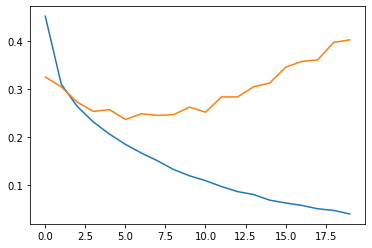

In [46]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])

In [48]:
# 케라스로 CNN 만들기
from tensorflow.keras.layers import Dropout

# 드롭아웃 적용하기
conv2 = tf.keras.Sequential()  # 컨볼루션을 위한 모델을 하나 쌓기
conv2.add(Conv2D(10, (3,3), activation='relu', padding='same', input_shape=(28,28,1)))  # 합성곱층
conv2.add(MaxPooling2D((2,2)))  # 2x2로 maxpooling
conv2.add(Flatten())  # 완전 연결층에 연결
conv2.add(Dropout(0.5))
conv2.add(Dense(100, activation='relu'))  # 완전연결층으로 하기
conv2.add(Dense(10, activation='softmax'))  # 완전연결층 10개로 소프트맥스

conv2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 10)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1960)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1960)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               196100    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
________________________________________________